<a href="https://colab.research.google.com/github/EmilisGit/Deep_learning/blob/main/bert_finetuning_with_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
!pip install transformers==4.47.0 datasets==3.2.0 -q

In [98]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import transformers
import os
import datasets
from transformers import DataCollatorForSeq2Seq

from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
print("Transformers " + transformers.__version__)
print("Datasets " + datasets.__version__)

Transformers 4.47.0
Datasets 3.2.0


In [99]:
#@title Import Dataset
hfDataset = load_dataset("ambrosfitz/10k_history_summary")
split = hfDataset['train'].train_test_split(test_size=0.2)
hfDataset['train'] = split['train'].shuffle(seed=42).select(range(3000))
hfDataset['test'] = split['test'].shuffle(seed=42).select(range(300))

hfDataset.save_to_disk("/content/hfDataset")

Saving the dataset (0/1 shards):   0%|          | 0/3000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

In [100]:
INPUT_NAME = "text"
OUTPUT_NAME = "target"
hfDataset['train'][0]

{'text': 'In the first essay of the book "Empire and Ambition in Asia: China and the Philippines," Michael H. Hunt discusses the influence of American businesses, missionaries, and diplomats on the McKinley administration\'s efforts to protect U.S. interests in China. Despite Washington\'s hesitance to divide China, Secretary of State John Hay\'s notes were seen as a logical yet ineffective method of managing the great powers and safeguarding American interests. In the second essay, Paul A. Kramer examines the U.S.-Philippine War from a racial perspective. U.S. officials rejected Filipino calls for self-government by labeling the Philippine population as "tribal" rather than national. American soldiers further racialized the colonial endeavor by associating Filipinos with minority groups within the U.S. and creating derogatory racial terms like "gu-gu" to identify the indigenous population. These stereotypes enabled U.S. authorities to dismiss guerrilla warfare tactics as "savage," jus

In [101]:
import numpy as np
import math

input_lengths = [len(tokenizer.encode(sentence)) for sentence in hfDataset['train'][INPUT_NAME]]
output_lengths = [len(tokenizer.encode(sentence)) for sentence in hfDataset['train'][OUTPUT_NAME]]
print(f"Average input length: {math.floor(np.mean(input_lengths))}")
print(f"Max input length: {np.max(input_lengths)}")
print(f"Average output length: {math.floor(np.mean(output_lengths))}")
print(f"Max output length: {np.max(output_lengths)}")


Average input length: 219
Max input length: 559
Average output length: 83
Max output length: 320


In [102]:
# Load model directly
BASE_MODEL = "facebook/bart-base"
model = TFAutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [103]:
test_text = hfDataset['test'][INPUT_NAME][16]
test_text

'In this tumultuous period of religious and cultural upheaval, the execution of don Toms Huilacapitzin serves as a stark reminder of the clash between indigenous beliefs and the imposition of Spanish authority. The Franciscans, adamant in their mission to convert the native population, arrested and sentenced don Toms to death, a fate witnessed by nobility from various sub-altepetls. The memory of his hanging, with his dog faithfully by his side until the end, lingered vividly in the minds of the onlookers. The brutal punishment extended to others accused of assisting don Toms, culminating in public shaming under the scorching sun. Amidst the confusion and fear sparked by these events, indigenous communities sought to navigate the demands of the new religion while preserving their reverence for the ancient gods. Smoking Shield don Alonso and his people, faced with the directive to construct a stone church, embraced the task with determination and pride, envisioning a structure that woul

In [104]:
def Summarize_text(text):
    inference_text = tokenizer("Summarize: " + text, return_tensors="tf", max_length=600, padding="max_length", truncation=True)

    outputs = model.generate(
        input_ids=inference_text["input_ids"],
        attention_mask=inference_text["attention_mask"],
        max_length=100,
        early_stopping=True
    )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text
Summarize_text(test_text)

'Summarize: In this tumultuous period of religious and cultural upheaval, the execution of don Toms Huilacapitzin serves as a stark reminder of the clash between indigenous beliefs and the imposition of Spanish authority. The Franciscans, adamant in their mission to convert the native population, arrested and sentenced don Tom to death, a fate witnessed by nobility from various sub-altepetls. The memory of his hanging, with his dog faithfully by his side until the'

In [105]:
def preprocess_data(examples):
    inputs = ["Summarize: " + ex for ex in examples[INPUT_NAME]]
    model_inputs = tokenizer(inputs, max_length=600, truncation=True, padding="max_length")
    model_inputs["input_ids"] = [inp for inp in model_inputs["input_ids"]]

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples[OUTPUT_NAME], max_length=100, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

encoded_dataset = hfDataset.map(preprocess_data, batched=True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

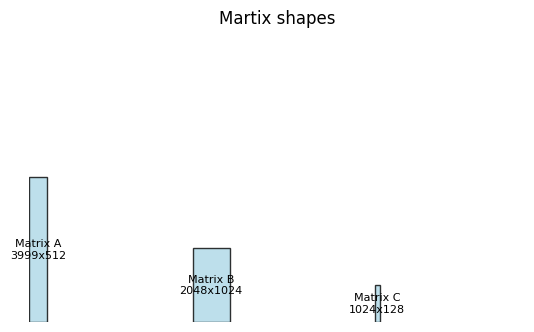

In [107]:
#@title Plot Matrices
def plot_matrices(matrices, labels=None, max_height=10, max_width=10):
    """
    Visualizes the shapes of large NumPy matrices as scaled rectangles.

    Parameters:
    - matrices: List of NumPy arrays
    - labels: Optional list of labels for the matrices
    - max_height: Maximum height of the largest rectangle in the plot
    - max_width: Maximum width of the largest rectangle in the plot
    """
    fig, ax = plt.subplots()
    current_x = 0

    # Determine scaling factors
    max_rows = max(matrix.shape[0] for matrix in matrices)
    max_cols = max(matrix.shape[1] for matrix in matrices)
    scale = max(max_rows, max_cols)

    for i, matrix in enumerate(matrices):
        rows, cols = matrix.shape
        scaled_rows = rows / scale
        scaled_cols = cols / scale

        # Draw rectangle
        rect = plt.Rectangle(
            (current_x, 0), scaled_cols, scaled_rows, edgecolor='black', facecolor='lightblue', alpha=0.8
        )
        ax.add_patch(rect)

        # Add label
        if labels and i < len(labels):
            ax.text(
                current_x + scaled_cols / 2, scaled_rows / 2,
                f"{labels[i]}\n{rows}x{cols}", ha='center', va='center', fontsize=8
            )

        current_x += scaled_cols + 1  # Add space between matrices

    # Set limits and display
    ax.set_xlim(0, current_x)
    ax.set_ylim(0, max(matrix.shape[0] / scale for matrix in matrices) + 1)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.xlabel('Columns (scaled)')
    plt.ylabel('Rows (scaled)')
    plt.title('Martix shapes')
    plt.show()

# Example usage with large matrices
matrices = [
    np.random.rand(3999, 512),
    np.random.rand(2048, 1024),
    np.random.rand(1024, 128)
]
labels = ["Matrix A", "Matrix B", "Matrix C"]
plot_matrices(matrices, labels)


Kiek turime apmokymo duomenų (mėginių)?

In [108]:
print("Apmokymo duomenu: ", len(hfDataset['train']))
print("Testavimo duomenu: ", len(hfDataset['test']))

Apmokymo duomenu:  3000
Testavimo duomenu:  300


Toliau naudosime tik dalį atsiliepimų viso proceso greitinimui:

In [109]:
training_data = encoded_dataset['train']
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors="tf")

tf_train_dataset = training_data.to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=8,
)

tf_train_dataset

<_PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(None, 600), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 600), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None, 100), dtype=tf.int64, name=None)}>

In [110]:
tf_train_dataset

<_PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(None, 600), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 600), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None, 100), dtype=tf.int64, name=None)}>

In [ ]:
model.compile(optimizer="adam")
model.fit(tf_train_dataset, epochs=3)

Epoch 1/3
375/375 [==============================] - 384s 869ms/step - loss: 7.7756
Epoch 2/3
375/375 [==============================] - 327s 873ms/step - loss: 7.8964
Epoch 3/3
127/375 [=========>....................] - ETA: 3:36 - loss: 7.6319

Pastebekime kad po tokenizavimo mūsų `Dataset` objectas gavo naujas savybes (stulpelius, raktažodžius) - `'input_ids'`, `'token_type_ids'` ir `'attention_mask'`:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save_pretrained("/content/drive/MyDrive/Colab/Summarization_t5_eff_small_v2.keras")

In [ ]:
test_text = hfDataset['test'][0]['text']
test_text

In [ ]:
Summarize_text(test_text)